In [1]:
import tensorflow
from keras.utils import np_utils
import numpy as np
print(tensorflow.__version__)

2.12.0


#Exploratory Data Analysis and Data Processing


In [2]:
import cv2,os
List_of_Images=[]
Class_of_Images=[]

# os.listdir() => list all the files and directories inside a specified directory
directory='./MedicalExpert-I'
# The files which are present directory are all catergorical
# Possess Data files of Each category
categories=os.listdir(directory)
# Labels
# Labels=['Healthy','Doubtful','Mild','Moderate','Critical']
Hot_encoder={}
# Assigning the labels same as that of the folders
for i in range(len(categories)) :
  Hot_encoder.update({categories[i]:i})
print(f"Labels for Arithritis Severity Classification :{categories}")
print(Hot_encoder)

Labels for Arithritis Severity Classification :['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
{'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}


# Image Processing

In [3]:
#!pip install -U scikit-learn

In [4]:
for x in categories:
    # Remember we have assigned our Categories from our folder names
    # So, In order to get the directory of the image's class we have to append it's name
    dir=os.path.join(directory,x)
    Images=os.listdir(dir)
        
    for image_name in Images:
        img_path=os.path.join(dir,image_name)
        # Reading images form the path
        img=cv2.imread(img_path)
        # Let's Try to process the image => Gray Scaling and Resizing
        try:
          # Now we will convert the coloured images to RBG to Gray Scale
            BWimage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Now, let's resize all of the images to a fixed dimension => 256 x 256
            # So, that we won't face any problem in near future  
            resized=cv2.resize(BWimage,(256,256))
            #resizing the image  into 256 x 256, since we need a fixed common size for all the images in the dataset
            List_of_Images.append(resized)
            # Now let's store our resized and Gray scaled images in an array
            Class_of_Images.append(Hot_encoder[x])
            #appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print(f" The following Error occured while trying to retrieve an image file :{e}")
            #if any exception rasied, the exception will be printed here. 
            # The cause of error will be printed or displayed And pass to the next image

# Rescale and assign  catagorical labels

In [5]:
List_of_Images=np.array(List_of_Images)
data=np.reshape(List_of_Images/255.0,(List_of_Images.shape[0],256,256,1))
new_label=np_utils.to_categorical(np.array(Class_of_Images))

In [6]:
new_label.shape

(1650, 5)

#CNN Model

In [7]:
data.shape

(1650, 256, 256, 1)

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.initializers import TruncatedNormal
from keras.regularizers import l2

# Model Creation
Knee_Arithritis_model=Sequential()

# Our first CNN Layer (Input Layer)
Knee_Arithritis_model.add(Conv2D(128,(3,3),input_shape=data.shape[1:], kernel_regularizer=l2(0.01), kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42)))
# We have chosen Leaky ReLu activation function for binary classification
Knee_Arithritis_model.add(Activation('LeakyReLU'))

# Pooling layers provide an approach to down sampling feature maps
# We can get rid of the huge redundant Data
# The most common pooling methods are MaxPooling Method and Average Pooling
# MaxPooling maps fixed size of pixels to their max value

# Let's prefer Average Pooling
Knee_Arithritis_model.add(AveragePooling2D(pool_size=(2,2)))

# Our second CNN Layer (1st Hidden Layer)
Knee_Arithritis_model.add(Conv2D(64,(3,3), kernel_regularizer=l2(0.01), kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42)))
Knee_Arithritis_model.add(Activation('LeakyReLU'))
Knee_Arithritis_model.add(AveragePooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

# Our third CNN Layer (1st Hidden Layer)
Knee_Arithritis_model.add(Conv2D(32,(3,3), kernel_regularizer=l2(0.01), kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42)))
Knee_Arithritis_model.add(Activation('LeakyReLU'))
Knee_Arithritis_model.add(MaxPooling2D(pool_size=(2,2)))

Knee_Arithritis_model.add(Flatten())
#Flatten layer to stack the output convolutions from 3rd convolution layer
Knee_Arithritis_model.add(Dropout(0.2))

Knee_Arithritis_model.add(Dense(128,activation='relu'))
#Dense layer of 128 neurons

Knee_Arithritis_model.add(Dropout(0.5))
Knee_Arithritis_model.add(Dense(64,activation='relu'))
#Dense layer of 64 neurons
Knee_Arithritis_model.add(Dropout(0.4))
Knee_Arithritis_model.add(Dense(5,activation='softmax'))
#The Final layer with 5 nodes for 5 categories

Knee_Arithritis_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
Knee_Arithritis_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     1280      
                                                                 
 activation (Activation)     (None, 254, 254, 128)     0         
                                                                 
 average_pooling2d (AverageP  (None, 127, 127, 128)    0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 125, 125, 64)      0         
                                                                 
 average_pooling2d_1 (Averag  (None, 62, 62, 64)       0         
 ePooling2D)                                            

# Splitting data into traning and testing

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,new_label,test_size=0.2)

In [11]:
#!pip install matplotlib

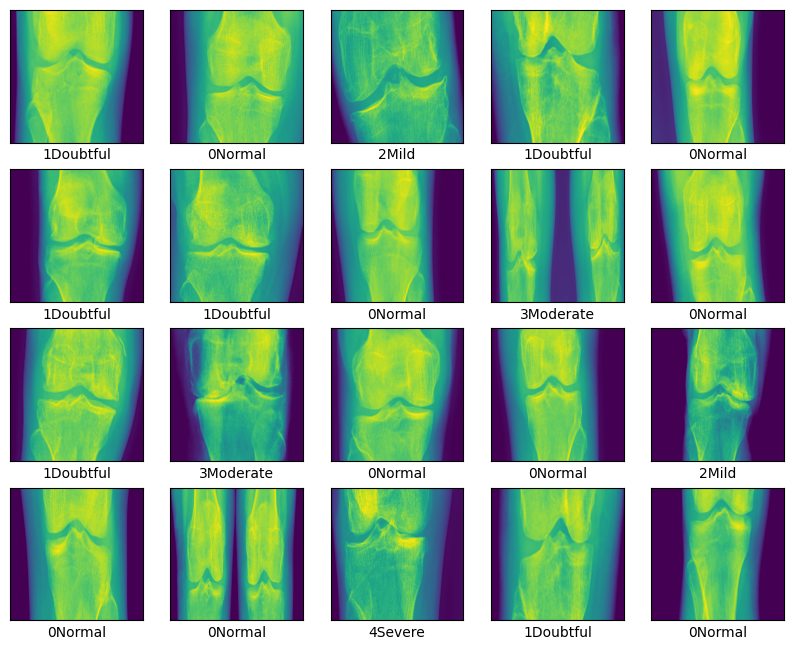

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]))
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.show()

In [13]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = Knee_Arithritis_model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop])


Epoch 1/100
33/33 [==============================] - 206s 6s/step - loss: 2.9999 - accuracy: 0.2689 - val_loss: 2.6042 - val_accuracy: 0.3258
Epoch 2/100
33/33 [==============================] - 195s 6s/step - loss: 2.4316 - accuracy: 0.3125 - val_loss: 2.2252 - val_accuracy: 0.3523
Epoch 3/100
33/33 [==============================] - 194s 6s/step - loss: 2.1200 - accuracy: 0.3371 - val_loss: 2.0017 - val_accuracy: 0.3144
Epoch 4/100
33/33 [==============================] - 194s 6s/step - loss: 1.9440 - accuracy: 0.3153 - val_loss: 1.8366 - val_accuracy: 0.3295
Epoch 5/100
33/33 [==============================] - 195s 6s/step - loss: 1.8206 - accuracy: 0.3220 - val_loss: 1.7837 - val_accuracy: 0.2917
Epoch 6/100
33/33 [==============================] - 193s 6s/step - loss: 1.7424 - accuracy: 0.3182 - val_loss: 1.6872 - val_accuracy: 0.3258
Epoch 7/100
33/33 [==============================] - 192s 6s/step - loss: 1.6756 - accuracy: 0.3371 - val_loss: 1.6439 - val_accuracy: 0.3561
Epoch 

In [17]:
Knee_Arithritis_model.save('ML.h5')

In [18]:
from matplotlib import pyplot as plt

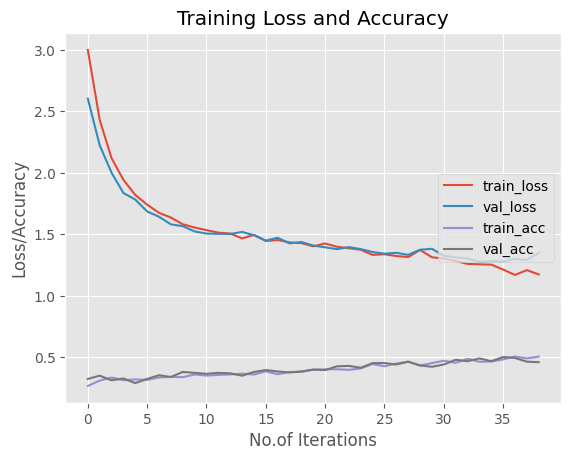

In [19]:
# plot the training loss and accuracy
N = 39 #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("No.of Iterations")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

In [20]:
vaL_loss, val_accuracy= Knee_Arithritis_model.evaluate(x_test, y_test, verbose=0)
print("test loss:", vaL_loss,'%')
print("test accuracy:", val_accuracy,"%")

test loss: 1.1991691589355469 %
test accuracy: 0.49696969985961914 %


1/1 [==============================] - 0s 241ms/step
Model Prediction: 0Normal
Actual label 0 is 0Normal


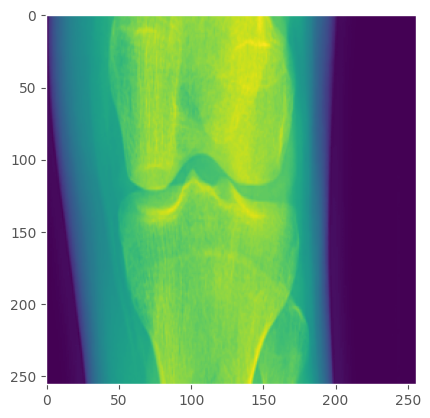

In [21]:
X = 7

img_size = 256

img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = (np.expand_dims(img_single, 0))
img_single = img_single.reshape(img_single.shape[0],256,256,1)

predictions_single = Knee_Arithritis_model.predict(img_single)
print('Model Prediction:',categories[np.argmax(predictions_single)])
print("Actual label",np.argmax(y_test[X]),'is',categories[np.argmax(y_test[X])])
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()

In [22]:
#!pip install mlxtend


11/11 [==============================] - 16s 1s/step


<Figure size 640x480 with 0 Axes>

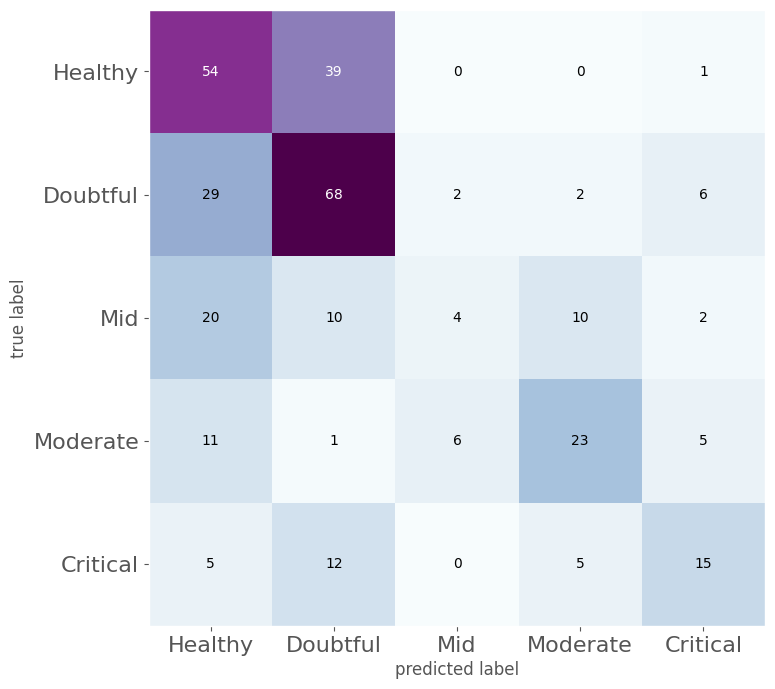

In [23]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

test_labels = np.argmax(y_test, axis=1)
predictions = Knee_Arithritis_model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)


cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), cmap='BuPu')
plt.xticks(range(5), ['Healthy','Doubtful','Mid','Moderate','Critical'], fontsize=16)
plt.yticks(range(5), ['Healthy','Doubtful','Mid','Moderate','Critical'], fontsize=16)
plt.show()